<a href="https://colab.research.google.com/github/IsabeleVitorio/Chords/blob/main/Supernova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install emcee


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import emcee
import matplotlib.pyplot as plt

In [ ]:

import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import emcee
import matplotlib.pyplot as plt

# ====================================
# 1. Load and Prepare the Input Data
# ====================================
df = pd.read_csv("supernova_data.csv")

z_helio = df["zhel"].values
z_cmb = df["zcmb"].values
ra = df["RA"].values
dec = df["Dec"].values

# Use z_cmb as "true" redshift for computing distances
fiducial_cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dL = fiducial_cosmo.luminosity_distance(z_cmb).value  # in Mpc

mu_obs = 5 * np.log10(dL) + 25  # distance modulus
mu_err = np.full_like(mu_obs, 0.15)  # assume 0.15 mag error

# ====================================
# 2. Redshift Correction Function
# ====================================
def correct_redshifts(z_helio, ra, dec, v_vec):
    c = 299792.458  # km/s
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    n_hat = np.array([coords.cartesian.x.value,
                      coords.cartesian.y.value,
                      coords.cartesian.z.value]).T
    v_los = np.dot(n_hat, v_vec)
    z_corr = (1 + z_helio) * (1 - v_los / c) - 1
    return z_corr

# ====================================
# 3. Distance Modulus Model
# ====================================
def model_mu(z, H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    dL = cosmo.luminosity_distance(z).value  # Mpc
    return 5 * np.log10(dL) + 25


In [ ]:

# ================================
# 4. MCMC: Likelihood and Priors
# ================================
def log_likelihood(params, z, mu_obs, mu_err):
    H0, Om0 = params
    try:
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
        dL = cosmo.luminosity_distance(z).to(u.Mpc).value

        # Defensive check: distance must be finite and positive
        if np.any(np.isnan(dL)) or np.any(dL <= 0):
            return -np.inf

        mu_model = 5 * np.log10(dL) + 25

        # Final safety check
        if np.any(np.isnan(mu_model)) or np.any(~np.isfinite(mu_model)):
            return -np.inf

        return -0.5 * np.sum(((mu_obs - mu_model) / mu_err) ** 2)

    except Exception as e:
        return -np.inf

def log_prior(theta):
    H0, Om0 = theta
    if 50 < H0 < 90 and 0.0 < Om0 < 1.0:
        return 0.0
    return -np.inf

def log_posterior(theta, z, mu, mu_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mu, mu_err)


In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
import emcee

# ================================
# 5. Run MCMC Sampler
# ================================
def run_mcmc(z, mu, mu_err, nsteps=1000):
    ndim = 2
    nwalkers = 10
    initial = np.array([70, 0.3])
    pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, mu, mu_err))
    sampler.run_mcmc(pos, nsteps, progress=True)
    return sampler


# 6. Generate Multiple Random Peculiar Velocities
def generate_random_velocities(n, min_mag=340, max_mag=380):
    mags = np.random.uniform(min_mag, max_mag, size=n)
    phi = np.random.uniform(0, 2 * np.pi, size=n)
    theta = np.arccos(2 * np.random.rand(n) - 1)

    x = mags * np.sin(theta) * np.cos(phi)
    y = mags * np.sin(theta) * np.sin(phi)
    z = mags * np.cos(theta)

    velocities = np.stack([x, y, z], axis=1)
    norms = np.linalg.norm(velocities, axis=1)
    print("Generated velocity magnitudes:", norms.round(2))
    return velocities

# 7. Main Analysis Loop (using pre-generated velocities)
n_trials = 4
results = []

velocity_vectors = generate_random_velocities(n_trials)

for i, v_vec in enumerate(velocity_vectors):
    print(f"\n=== Trial {i+1} ===")
    print(f"Using velocity vector: {v_vec.round(2)} km/s")

    z_corr = correct_redshifts(z_helio, ra, dec, v_vec)
    sampler = run_mcmc(z_corr, mu_obs, mu_err)

    samples = sampler.get_chain(discard=200, flat=True)
    H0_median, Om0_median = np.median(samples, axis=0)
    H0_std, Om0_std = np.std(samples, axis=0)

    results.append((v_vec, H0_median, H0_std, Om0_median, Om0_std))

    print(f"→ H0 = {H0_median:.2f} ± {H0_std:.2f}, Ωm = {Om0_median:.2f} ± {Om0_std:.2f}")

# 8. Save Results
results_df = pd.DataFrame(results, columns=["v_vec", "H0", "H0_err", "Om0", "Om0_err"])
results_df.to_csv("velocity_trial_results.csv", index=False)



Generated velocity magnitudes: [359.06 367.81 371.27 352.06]

=== Trial 1 ===
Using velocity vector: [ 252.65  -35.84 -252.59] km/s


100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


→ H0 = 70.41 ± 0.14, Ωm = 0.29 ± 0.01

=== Trial 2 ===
Using velocity vector: [-282.77  106.81 -209.57] km/s


100%|██████████| 1000/1000 [03:51<00:00,  4.32it/s]


→ H0 = 69.47 ± 0.14, Ωm = 0.34 ± 0.01

=== Trial 3 ===
Using velocity vector: [  32.49 -362.79   71.9 ] km/s


100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


→ H0 = 69.75 ± 0.14, Ωm = 0.32 ± 0.01

=== Trial 4 ===
Using velocity vector: [-181.86 -188.02  235.63] km/s


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


→ H0 = 70.00 ± 0.00, Ωm = 0.30 ± 0.00


✅ Total clean rows: 4
✅ Velocity array shape: (4, 3)
✅ Sample vectors:
0: [ 252.65269127  -35.8399023  -252.59267418]
1: [-282.76555846  106.80782374 -209.57256042]
2: [  32.49176888 -362.7851329    71.90051263]
3: [-181.86159469 -188.02344264  235.62566865]


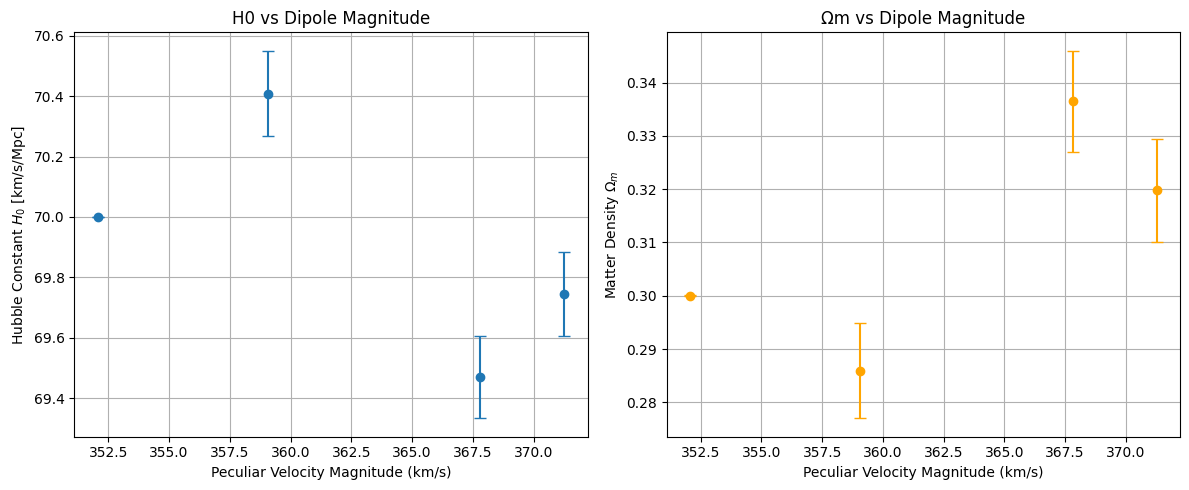

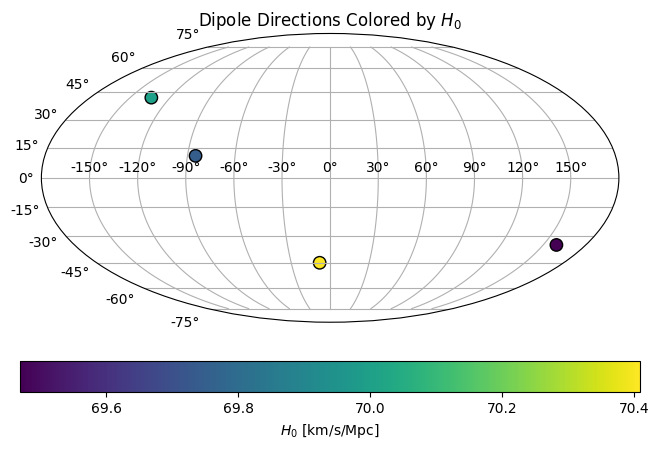

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and Clean Data
df = pd.read_csv("velocity_trial_results.csv")

def parse_vector(s):
    try:
        matches = re.findall(r"-?\d+\.\d+(?:[eE][-+]?\d+)?", s)
        vec = np.array([float(x) for x in matches])
        if len(vec) != 3:
            raise ValueError(f"Expected 3 elements, got {len(vec)}")
        return vec
    except Exception as e:
        print(f"❌ Failed to parse: {s} → {e}")
        return np.array([np.nan, np.nan, np.nan])

df["vec_parsed"] = df["v_vec"].apply(parse_vector)
valid_mask = df["vec_parsed"].apply(lambda x: not np.isnan(x).any())
df_clean = df[valid_mask].copy()
v_xyz = np.stack(df_clean["vec_parsed"])

print("✅ Total clean rows:", len(df_clean))
print("✅ Velocity array shape:", v_xyz.shape)
print("✅ Sample vectors:")
for i in range(min(5, len(v_xyz))):
    print(f"{i}: {v_xyz[i]}")

# 2. Calculate Velocity Magnitudes and Plot
vx, vy, vz = v_xyz[:, 0], v_xyz[:, 1], v_xyz[:, 2]
vmag = np.linalg.norm(v_xyz, axis=1)
df_valid = df_clean.reset_index(drop=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H0 vs |v|
ax[0].errorbar(vmag, df_valid["H0"], yerr=df_valid["H0_err"], fmt='o', capsize=4)
ax[0].set_xlabel("Peculiar Velocity Magnitude (km/s)")
ax[0].set_ylabel("Hubble Constant $H_0$ [km/s/Mpc]")
ax[0].set_title("H0 vs Dipole Magnitude")
ax[0].grid(True)

# Om0 vs |v|
ax[1].errorbar(vmag, df_valid["Om0"], yerr=df_valid["Om0_err"], fmt='o', capsize=4, color='orange')
ax[1].set_xlabel("Peculiar Velocity Magnitude (km/s)")
ax[1].set_ylabel("Matter Density $\\Omega_m$")
ax[1].set_title("Ωm vs Dipole Magnitude")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 3. Plot Dipole Directions (Mollweide)
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

unit_v = v_xyz / np.linalg.norm(v_xyz, axis=1)[:, None]
lon = np.arctan2(unit_v[:, 1], unit_v[:, 0])  # φ = arctan(y/x)
lat = np.arcsin(unit_v[:, 2])                 # θ = arcsin(z)

lon = np.radians((np.degrees(lon) + 180) % 360 - 180)
lat = np.radians(np.degrees(lat))

plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection="mollweide")
sc = ax.scatter(lon, lat, c=df_valid["H0"], cmap="viridis", edgecolor="k", s=80)
cb = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cb.set_label("$H_0$ [km/s/Mpc]")
ax.set_title("Dipole Directions Colored by $H_0$")
ax.grid(True)
plt.show()


Linear Fit: H0 = -0.0285 * |v| + 80.24
R² = 0.384
ΔH0 per 100 km/s = -2.85 km/s/Mpc


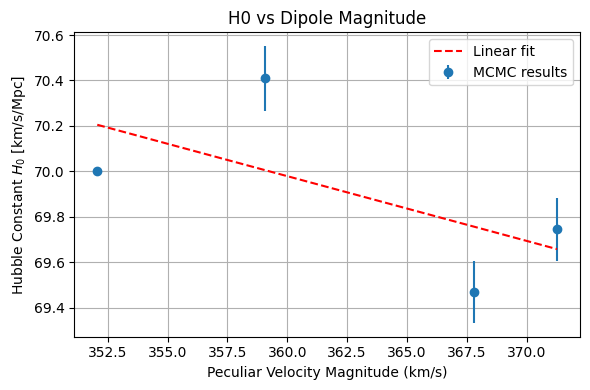

In [ ]:
from scipy.stats import linregress

# Fit linear regression: H0 vs |v|
slope, intercept, r_value, p_value, stderr = linregress(vmag, df_valid["H0"])

# Report results
print(f"Linear Fit: H0 = {slope:.4f} * |v| + {intercept:.2f}")
print(f"R² = {r_value**2:.3f}")
print(f"ΔH0 per 100 km/s = {slope * 100:.2f} km/s/Mpc")

# Optional: Plot with fit
plt.figure(figsize=(6, 4))
plt.errorbar(vmag, df_valid["H0"], yerr=df_valid["H0_err"], fmt='o', label='MCMC results')
x_fit = np.linspace(vmag.min(), vmag.max(), 100)
plt.plot(x_fit, slope * x_fit + intercept, 'r--', label='Linear fit')
plt.xlabel("Peculiar Velocity Magnitude (km/s)")
plt.ylabel("Hubble Constant $H_0$ [km/s/Mpc]")
plt.title("H0 vs Dipole Magnitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


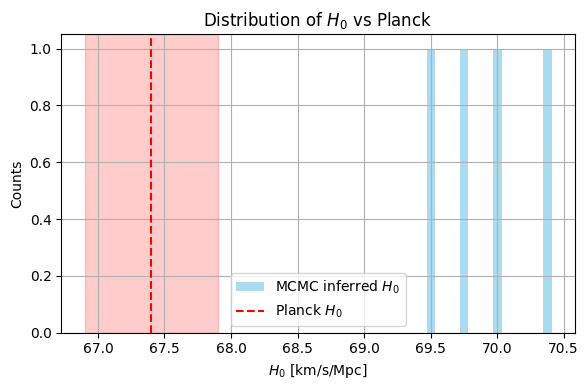

In [ ]:
H0_planck = 67.4
H0_planck_err = 0.5

# Plot histogram of your H0 posteriors
plt.figure(figsize=(6, 4))
plt.hist(df_valid["H0"], bins=15, alpha=0.7, label='MCMC inferred $H_0$', color='skyblue')
plt.axvline(H0_planck, color='red', linestyle='--', label='Planck $H_0$')
plt.axvspan(H0_planck - H0_planck_err, H0_planck + H0_planck_err, color='red', alpha=0.2)
plt.xlabel("$H_0$ [km/s/Mpc]")
plt.ylabel("Counts")
plt.title("Distribution of $H_0$ vs Planck")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



Estimated Fisher Matrix:
               H0           Om0            vx            vy            vz
H0  -4.246326e+16 -2.636203e+18 -2.773623e+14 -2.960557e+14 -2.987776e+14
Om0  1.577533e+18  2.007679e+19 -1.162091e+15 -9.182789e+14 -5.771868e+14
vx   3.431876e+14  9.839516e+15  5.530237e+11  6.377359e+11  6.950745e+11
vy   3.488836e+14  9.742481e+15  5.238617e+11  6.084730e+11  6.675656e+11
vz   3.331745e+14  9.007199e+15  4.565929e+11  5.356776e+11  5.930237e+11


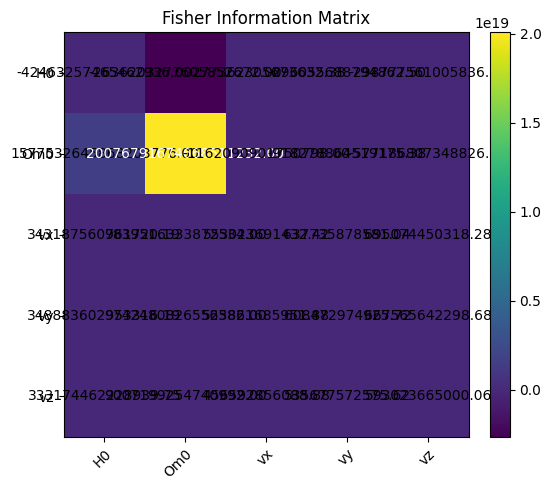

In [ ]:
# ===========================================
# 9. Fisher Matrix Estimation from Results
# ===========================================
# Expand velocity vector into components
v_components = np.stack(results_df["v_vec"].values)  # shape (n_trials, 3)
H0_vals = results_df["H0"].values
Om0_vals = results_df["Om0"].values

# Build parameter matrix: [H0, Om0, vx, vy, vz]
params_matrix = np.column_stack([H0_vals, Om0_vals, v_components])  # shape (n_trials, 5)

# Compute covariance matrix of parameters (empirical)
cov_matrix = np.cov(params_matrix.T)  # shape (5, 5)

# Invert to get Fisher matrix
fisher_matrix = np.linalg.inv(cov_matrix)

# Put into DataFrame for easy viewing/saving
param_names = ["H0", "Om0", "vx", "vy", "vz"]
fisher_df = pd.DataFrame(fisher_matrix, index=param_names, columns=param_names)

# Save and display
fisher_df.to_csv("fisher_matrix.csv")
print("\nEstimated Fisher Matrix:")
print(fisher_df.round(4))


stds = np.sqrt(np.diag(cov_matrix))
corr_matrix = cov_matrix / np.outer(stds, stds)


import matplotlib.pyplot as plt

# Plot Fisher Matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(fisher_df.values, cmap="viridis")

# Set ticks and labels
param_names = fisher_df.columns.tolist()
ax.set_xticks(np.arange(len(param_names)))
ax.set_yticks(np.arange(len(param_names)))
ax.set_xticklabels(param_names)
ax.set_yticklabels(param_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add value annotations
for i in range(len(param_names)):
    for j in range(len(param_names)):
        text = f"{fisher_df.values[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center", color="white" if fisher_df.values[i, j] > fisher_df.values.max() / 2 else "black")

ax.set_title("Fisher Information Matrix")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("fisher_matrix_plot.png", dpi=300)
plt.show()


## Test 2

In [6]:
!pip install corner




In [7]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import emcee
import matplotlib.pyplot as plt
import corner
from math import sqrt

# ====================================
# 1. Load and Prepare the Input Data
# ====================================
df = pd.read_csv("supernova_data.csv")

z_helio = df["zhel"].values
z_cmb = df["zcmb"].values
ra = df["RA"].values
dec = df["Dec"].values

fiducial_cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dL = fiducial_cosmo.luminosity_distance(z_cmb).value  # in Mpc
mu_obs = 5 * np.log10(dL) + 25
mu_err = np.full_like(mu_obs, 0.15)

# ====================================
# 2. Redshift Correction Function
# ====================================
def correct_redshifts(z_helio, ra, dec, v_vec):
    c = 299792.458  # km/s
    coords = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    n_hat = np.array([coords.cartesian.x.value,
                      coords.cartesian.y.value,
                      coords.cartesian.z.value]).T
    v_los = np.dot(n_hat, v_vec)
    z_corr = (1 + z_helio) * (1 - v_los / c) - 1
    return z_corr

# ====================================
# 3. MCMC Likelihood and Posterior
# ====================================
def log_likelihood(params, z, mu_obs, mu_err):
    H0, Om0 = params
    try:
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
        dL = cosmo.luminosity_distance(z).to(u.Mpc).value
        if np.any(np.isnan(dL)) or np.any(dL <= 0):
            return -np.inf
        mu_model = 5 * np.log10(dL) + 25
        if np.any(np.isnan(mu_model)) or np.any(~np.isfinite(mu_model)):
            return -np.inf
        return -0.5 * np.sum(((mu_obs - mu_model) / mu_err) ** 2)
    except Exception:
        return -np.inf

def log_prior(theta):
    H0, Om0 = theta
    if 50 < H0 < 90 and 0.0 < Om0 < 1.0:
        return 0.0
    return -np.inf

def log_posterior(theta, z, mu, mu_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mu, mu_err)

# ====================================
# 4. Run MCMC Sampler
# ====================================
def run_mcmc(z, mu, mu_err, nsteps=1000):
    ndim = 2
    nwalkers = 10
    initial = np.array([70, 0.3])
    pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, mu, mu_err))
    sampler.run_mcmc(pos, nsteps, progress=True)
    return sampler

# ====================================
# 5. Generate Random Velocity Vectors
# ====================================
max_mag = 300
min_mag = 330
def generate_random_velocities(n, min_mag=min_mag, max_mag=max_mag):
    mags = np.random.uniform(min_mag, max_mag, size=n)
    phi = np.random.uniform(0, 2 * np.pi, size=n)
    theta = np.arccos(2 * np.random.rand(n) - 1)
    x = mags * np.sin(theta) * np.cos(phi)
    y = mags * np.sin(theta) * np.sin(phi)
    z = mags * np.cos(theta)
    velocities = np.stack([x, y, z], axis=1)
    return velocities

# ====================================
# 6. Main Analysis Loop
# ====================================
n_trials = 30
velocity_vectors = generate_random_velocities(n_trials)
results = []
all_samples = []

for i, v_vec in enumerate(velocity_vectors):
    print(f"\n=== Trial {i+1} ===")
    print(f"Velocity Vector: {v_vec.round(2)} km/s")

    z_corr = correct_redshifts(z_helio, ra, dec, v_vec)
    sampler = run_mcmc(z_corr, mu_obs, mu_err)

    samples = sampler.get_chain(discard=200, flat=True)
    v_mag = np.linalg.norm(v_vec)
    v_column = np.full((samples.shape[0], 1), v_mag)
    samples_with_v = np.hstack([samples, v_column])
    all_samples.append(samples_with_v)

    H0_median, Om0_median = np.median(samples, axis=0)
    H0_std, Om0_std = np.std(samples, axis=0)

    results.append((v_vec, H0_median, H0_std, Om0_median, Om0_std))

    print(f"→ H0 = {H0_median:.2f} ± {H0_std:.2f}, Ωm = {Om0_median:.2f} ± {Om0_std:.2f}")

# ====================================
# 7. Save Summary Results
# ====================================
results_df = pd.DataFrame(results, columns=["v_vec", "H0", "H0_err", "Om0", "Om0_err"])
results_df.to_csv("velocity_trial_results.csv", index=False)





=== Trial 1 ===
Velocity Vector: [ 254.52  103.63 -130.82] km/s


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]


→ H0 = 70.10 ± 0.14, Ωm = 0.30 ± 0.01

=== Trial 2 ===
Velocity Vector: [-239.64 -119.28  173.29] km/s


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [03:56<00:00,  4.24it/s]


→ H0 = 70.00 ± 0.00, Ωm = 0.30 ± 0.00

=== Trial 3 ===
Velocity Vector: [  45.07 -289.67  126.89] km/s


100%|██████████| 1000/1000 [03:55<00:00,  4.24it/s]


→ H0 = 69.61 ± 0.15, Ωm = 0.32 ± 0.01

=== Trial 4 ===
Velocity Vector: [ 173.39 -260.99    2.56] km/s


100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]


→ H0 = 70.06 ± 0.15, Ωm = 0.30 ± 0.01

=== Trial 5 ===
Velocity Vector: [ 169.37 -246.1   -73.06] km/s


100%|██████████| 1000/1000 [03:57<00:00,  4.21it/s]


→ H0 = 70.19 ± 0.14, Ωm = 0.30 ± 0.01

=== Trial 6 ===
Velocity Vector: [-329.78    2.31   -3.06] km/s


100%|██████████| 1000/1000 [03:51<00:00,  4.33it/s]


→ H0 = 68.97 ± 0.15, Ωm = 0.36 ± 0.01

=== Trial 7 ===
Velocity Vector: [ 219.64 -195.69   61.57] km/s


100%|██████████| 1000/1000 [03:56<00:00,  4.22it/s]


→ H0 = 69.92 ± 0.15, Ωm = 0.31 ± 0.01

=== Trial 8 ===
Velocity Vector: [286.93 118.02 -37.54] km/s


100%|██████████| 1000/1000 [03:55<00:00,  4.25it/s]


→ H0 = 69.95 ± 0.14, Ωm = 0.30 ± 0.01

=== Trial 9 ===
Velocity Vector: [-296.42  -26.1  -114.4 ] km/s


100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


→ H0 = 69.35 ± 0.15, Ωm = 0.34 ± 0.01

=== Trial 10 ===
Velocity Vector: [-228.47  185.78 -124.11] km/s


100%|██████████| 1000/1000 [03:49<00:00,  4.37it/s]


→ H0 = 69.36 ± 0.15, Ωm = 0.34 ± 0.01

=== Trial 11 ===
Velocity Vector: [  28.34 -173.51 -261.95] km/s


100%|██████████| 1000/1000 [03:51<00:00,  4.32it/s]


→ H0 = 70.30 ± 0.14, Ωm = 0.30 ± 0.01

=== Trial 12 ===
Velocity Vector: [-281.69  122.55  -54.15] km/s


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


→ H0 = 69.15 ± 0.14, Ωm = 0.35 ± 0.01

=== Trial 13 ===
Velocity Vector: [  79.33 -285.21  -57.34] km/s


100%|██████████| 1000/1000 [03:52<00:00,  4.31it/s]


→ H0 = 70.07 ± 0.14, Ωm = 0.30 ± 0.01

=== Trial 14 ===
Velocity Vector: [ 135.86 -273.49  -66.42] km/s


100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s]


→ H0 = 70.15 ± 0.14, Ωm = 0.30 ± 0.01

=== Trial 15 ===
Velocity Vector: [ -17.05 -293.58  120.17] km/s


100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


→ H0 = 69.53 ± 0.15, Ωm = 0.33 ± 0.01

=== Trial 16 ===
Velocity Vector: [  66.69 -310.41   31.61] km/s


100%|██████████| 1000/1000 [03:50<00:00,  4.33it/s]


→ H0 = 69.89 ± 0.15, Ωm = 0.31 ± 0.01

=== Trial 17 ===
Velocity Vector: [ 300.02   49.42 -107.19] km/s


100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


→ H0 = 70.14 ± 0.14, Ωm = 0.29 ± 0.01

=== Trial 18 ===
Velocity Vector: [-135.49  -96.58  253.68] km/s


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


→ H0 = 70.00 ± 0.00, Ωm = 0.30 ± 0.00

=== Trial 19 ===
Velocity Vector: [ -64.5  -308.09  -12.57] km/s


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


→ H0 = 69.79 ± 0.15, Ωm = 0.32 ± 0.01

=== Trial 20 ===
Velocity Vector: [-185.99  134.42 -232.2 ] km/s


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


→ H0 = 69.68 ± 0.15, Ωm = 0.32 ± 0.01

=== Trial 21 ===
Velocity Vector: [ 209.76 -226.06   69.47] km/s


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


→ H0 = 69.93 ± 0.15, Ωm = 0.31 ± 0.01

=== Trial 22 ===
Velocity Vector: [255.32   4.07 170.04] km/s


100%|██████████| 1000/1000 [03:49<00:00,  4.35it/s]


→ H0 = 69.60 ± 0.14, Ωm = 0.32 ± 0.01

=== Trial 23 ===
Velocity Vector: [-160.28  277.03    3.63] km/s


100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]


→ H0 = 69.16 ± 0.14, Ωm = 0.35 ± 0.01

=== Trial 24 ===
Velocity Vector: [273.51 113.84 -81.79] km/s


100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s]


→ H0 = 70.00 ± 0.15, Ωm = 0.30 ± 0.01

=== Trial 25 ===
Velocity Vector: [ 68.43  46.81 290.8 ] km/s


100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


→ H0 = 70.00 ± 0.00, Ωm = 0.30 ± 0.00

=== Trial 26 ===
Velocity Vector: [  13.16  125.02 -287.61] km/s


100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s]


→ H0 = 70.09 ± 0.15, Ωm = 0.30 ± 0.01

=== Trial 27 ===
Velocity Vector: [ 169.19  -91.97 -250.62] km/s


100%|██████████| 1000/1000 [03:50<00:00,  4.33it/s]


→ H0 = 70.37 ± 0.15, Ωm = 0.29 ± 0.01

=== Trial 28 ===
Velocity Vector: [ 150.67 -213.94 -175.84] km/s


100%|██████████| 1000/1000 [03:49<00:00,  4.35it/s]


→ H0 = 70.34 ± 0.14, Ωm = 0.29 ± 0.01

=== Trial 29 ===
Velocity Vector: [-134.61 -222.28  168.74] km/s


100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


→ H0 = 70.00 ± 0.00, Ωm = 0.30 ± 0.00

=== Trial 30 ===
Velocity Vector: [321.01 -24.55 -29.53] km/s


100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


→ H0 = 70.10 ± 0.14, Ωm = 0.30 ± 0.01


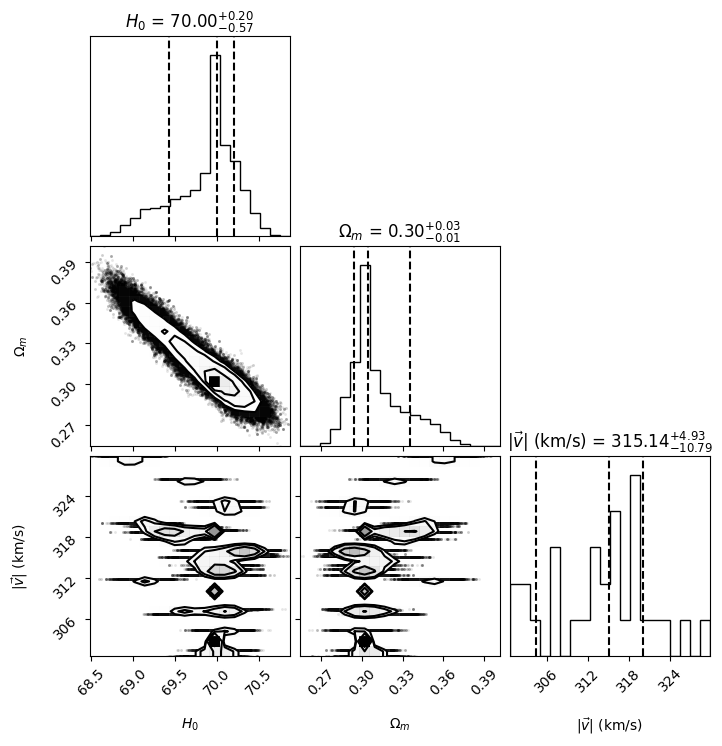

330 300
30


In [8]:
# ====================================
# 8. Plot Posterior Distributions
# ====================================

results_df = pd.DataFrame(results, columns=["v_vec", "H0", "H0_err", "Om0", "Om0_err"])
results_df.to_csv("velocity_trial_results.csv", index=False)

combined_samples = np.vstack(all_samples)
labels = ["$H_0$", r"$\Omega_m$", r"$|\vec{v}|$ (km/s)"]
fig = corner.corner(combined_samples, labels=labels, show_titles=True, title_fmt=".2f", quantiles=[0.16, 0.5, 0.84])
#plt.suptitle("Corner Plot of Posterior Distributions")
plt.savefig("posterior_corner_plot_10.png", dpi=300)
plt.show()


print(min_mag, max_mag)
print(n_trials)


✅ Total clean rows: 30
✅ Velocity array shape: (30, 3)
✅ Sample vectors:
0: [ 254.51817494  103.63335316 -130.8168142 ]
1: [-239.63713966 -119.27860929  173.28987819]
2: [  45.06934476 -289.6705987   126.88913486]
3: [ 173.39106037 -260.98738195    2.55650886]
4: [ 169.36577282 -246.09905324  -73.05573372]


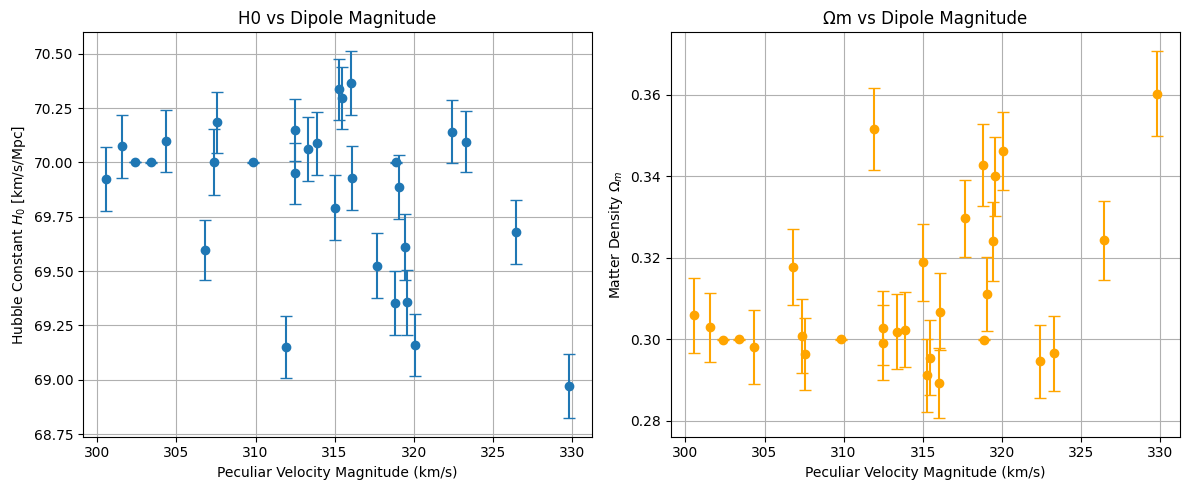

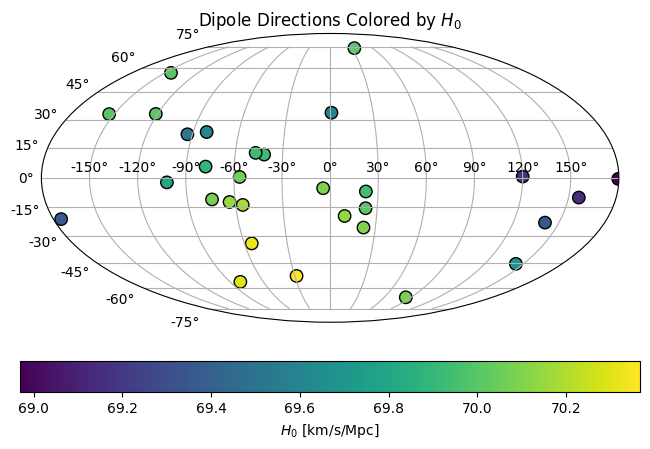

In [9]:

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and Clean Data
df = pd.read_csv("velocity_trial_results.csv")

def parse_vector(s):
    try:
        matches = re.findall(r"-?\d+\.\d+(?:[eE][-+]?\d+)?", s)
        vec = np.array([float(x) for x in matches])
        if len(vec) != 3:
            raise ValueError(f"Expected 3 elements, got {len(vec)}")
        return vec
    except Exception as e:
        print(f"❌ Failed to parse: {s} → {e}")
        return np.array([np.nan, np.nan, np.nan])

df["vec_parsed"] = df["v_vec"].apply(parse_vector)
valid_mask = df["vec_parsed"].apply(lambda x: not np.isnan(x).any())
df_clean = df[valid_mask].copy()
v_xyz = np.stack(df_clean["vec_parsed"])

print("✅ Total clean rows:", len(df_clean))
print("✅ Velocity array shape:", v_xyz.shape)
print("✅ Sample vectors:")
for i in range(min(5, len(v_xyz))):
    print(f"{i}: {v_xyz[i]}")

# 2. Calculate Velocity Magnitudes and Plot
vx, vy, vz = v_xyz[:, 0], v_xyz[:, 1], v_xyz[:, 2]
vmag = np.linalg.norm(v_xyz, axis=1)
df_valid = df_clean.reset_index(drop=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H0 vs |v|
ax[0].errorbar(vmag, df_valid["H0"], yerr=df_valid["H0_err"], fmt='o', capsize=4)
ax[0].set_xlabel("Peculiar Velocity Magnitude (km/s)")
ax[0].set_ylabel("Hubble Constant $H_0$ [km/s/Mpc]")
ax[0].set_title("H0 vs Dipole Magnitude")
ax[0].grid(True)

# Om0 vs |v|
ax[1].errorbar(vmag, df_valid["Om0"], yerr=df_valid["Om0_err"], fmt='o', capsize=4, color='orange')
ax[1].set_xlabel("Peculiar Velocity Magnitude (km/s)")
ax[1].set_ylabel("Matter Density $\\Omega_m$")
ax[1].set_title("Ωm vs Dipole Magnitude")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 3. Plot Dipole Directions (Mollweide)
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

unit_v = v_xyz / np.linalg.norm(v_xyz, axis=1)[:, None]
lon = np.arctan2(unit_v[:, 1], unit_v[:, 0])  # φ = arctan(y/x)
lat = np.arcsin(unit_v[:, 2])                 # θ = arcsin(z)

lon = np.radians((np.degrees(lon) + 180) % 360 - 180)
lat = np.radians(np.degrees(lat))

plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection="mollweide")
sc = ax.scatter(lon, lat, c=df_valid["H0"], cmap="viridis", edgecolor="k", s=80)
cb = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cb.set_label("$H_0$ [km/s/Mpc]")
ax.set_title("Dipole Directions Colored by $H_0$")
ax.grid(True)
plt.show()

Linear Fit: H0 = -0.0191 * |v| + 75.85
R² = 0.150
ΔH0 per 100 km/s = -1.91 km/s/Mpc


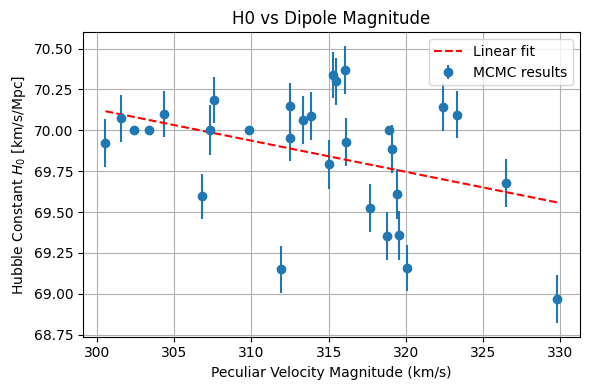

In [10]:
from scipy.stats import linregress

# Fit linear regression: H0 vs |v|
slope, intercept, r_value, p_value, stderr = linregress(vmag, df_valid["H0"])

# Report results
print(f"Linear Fit: H0 = {slope:.4f} * |v| + {intercept:.2f}")
print(f"R² = {r_value**2:.3f}")
print(f"ΔH0 per 100 km/s = {slope * 100:.2f} km/s/Mpc")

# Optional: Plot with fit
plt.figure(figsize=(6, 4))
plt.errorbar(vmag, df_valid["H0"], yerr=df_valid["H0_err"], fmt='o', label='MCMC results')
x_fit = np.linspace(vmag.min(), vmag.max(), 100)
plt.plot(x_fit, slope * x_fit + intercept, 'r--', label='Linear fit')
plt.xlabel("Peculiar Velocity Magnitude (km/s)")
plt.ylabel("Hubble Constant $H_0$ [km/s/Mpc]")
plt.title("H0 vs Dipole Magnitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

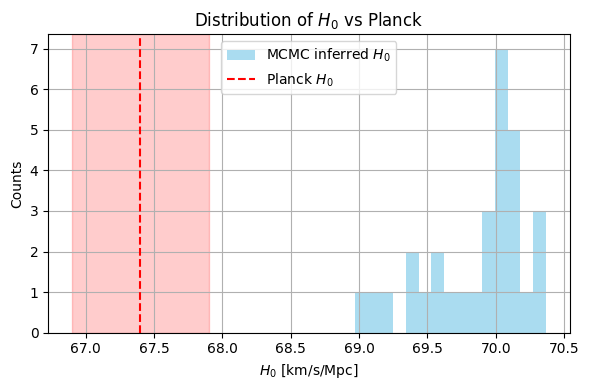

In [11]:
H0_planck = 67.4
H0_planck_err = 0.5

# Plot histogram of your H0 posteriors
plt.figure(figsize=(6, 4))
plt.hist(df_valid["H0"], bins=15, alpha=0.7, label='MCMC inferred $H_0$', color='skyblue')
plt.axvline(H0_planck, color='red', linestyle='--', label='Planck $H_0$')
plt.axvspan(H0_planck - H0_planck_err, H0_planck + H0_planck_err, color='red', alpha=0.2)
plt.xlabel("$H_0$ [km/s/Mpc]")
plt.ylabel("Counts")
plt.title("Distribution of $H_0$ vs Planck")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()